In [31]:
import numpy as np
import gymnasium as gym
import random
import time
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
import sys 
from IPython.display import display, clear_output

In [49]:
def plot_metrics(scores, epsilons):
    # Clear the matplotlib figure for the next plot
    plt.clf()

    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.plot(scores)
    plt.title('Score per Episode vs Episode')
    plt.xlabel('Episode')
    plt.ylabel('Score')

    plt.subplot(2, 1, 2)
    plt.plot(epsilons)
    plt.title('Epsilon vs Episode')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')

    plt.tight_layout()
    plt.savefig('metrics.png')
    # plt.show()

    # Display the plot
    display(plt.gcf())
    
    # Pause to give Jupyter time to update the display
    time.sleep(1)
    
    # Clear the output of the current cell
    clear_output(wait=True)

In [83]:
class Agent:
    def __init__(self, algorithm='SARSA'):
        self.algorithm = algorithm
        # self.env = gym.make("CartPole-v0",  render_mode="rgb_array")
        self.env = gym.make('CartPole-v1', render_mode='rgb_array')
        self.num_episodes = 300
        self.max_steps_per_episode = 500
        self.learning_rate = 0.4
        self.max_learning_rate = 0.4
        self.min_learning_rate = 0.1
        self.learning_rate_decay = 0.99
        self.discount_rate = 1.0
        self.epsilon = 1.0
        self.max_epsilon = 1.0
        self.min_epsilon = 0.01
        self.epsilon_decay_rate = 0.99
        # initialize 
        self.create_bins()
        self.initialize_q_table()

    def create_bins(self, bins=100):
        cart_pos_bins = np.linspace(-2.4, 2.4, bins+1)
        cart_vel_bins = np.linspace(-5.0, 5.0, bins+1)
        pole_ang_bins = np.linspace(-0.20, 0.20, bins+1)
        pole_tipvel_bins = np.linspace(-2.5, 2.5, bins+1)
        self.bins = [cart_pos_bins, cart_vel_bins, pole_ang_bins, pole_tipvel_bins]

    def discretize_state(self, observation):
        state_signal = 0  # row position in Q-matrix or eligibility trace, equivalent state
        bin_state = np.zeros_like(observation)
        for i in range(len(observation)):
            bin_state[i] = np.digitize(observation[i], self.bins[i])
            state_signal += bin_state[i] * ((len(self.bins[i]) + 1) ** i)
        return int(state_signal)

    def greedy_action_selection(self, state):
        return np.argmax(self.q_table[state, :])
    
    def eps_action_selection(self, state):
        epsilon_threshold = random.uniform(0,1)
        if epsilon_threshold > self.epsilon:
            # exploitation
            return np.argmax(self.q_table[state,:])
        else:
            # epsilon
            return self.env.action_space.sample()

    def initialize_q_table(self):
        num_states = (len(self.bins[0]) + 1) * (len(self.bins[1]) + 1) * (len(self.bins[2]) + 1) * (len(self.bins[3]) + 1)
        # self.q_table = np.zeros((num_states, self.env.action_space.n))
        self.q_table = np.random.rand(num_states, self.env.action_space.n)

        
    def decay_epsilon(self, episode):
        decay_factor = 1.0 - episode / self.num_episodes
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * decay_factor

    def decay_learning_rate(self, episode):
        decay_factor = 1.0 - episode / self.num_episodes
        self.learning_rate = self.min_learning_rate + (self.max_learning_rate - self.min_learning_rate) * decay_factor

    def train(self):

        # initialize arrays to keep track of rewards and epsilon
        self.scores = []
        self.epsilons = []

        # iterate over episodes
        for episode in tqdm(range(self.num_episodes)):
            
            # initialize new episode params
            state, _ = self.env.reset()
            state = self.discretize_state(state)
            done = False
            self.rewards = 0

            # select new action
            if self.algorithm == 'SARSA':
                action = self.eps_action_selection(state)
            
            # iterate over steps in episode
            for t in range(self.max_steps_per_episode): 
                self.env.render()
                
                # select new action 
                if self.algorithm == 'Q-learning':
                    action = self.eps_action_selection(state)

                # Take action 
                new_state, reward, done, _, _ = self.env.step(action)
                new_state = self.discretize_state(new_state)

                # Experimenting with very bad reward if agent fails
                # if done:
                    # reward = -100

                # select next action 
                if self.algorithm == 'SARSA':
                    new_action = self.eps_action_selection(new_state)
                
                # Update Q-table
                if self.algorithm == 'Q-learning':
                    self.q_table[state, action] += self.learning_rate * (reward + self.discount_rate * np.max(self.q_table[new_state, :]) - self.q_table[state, action])
                    # self.q_table[state, action] = self.q_table[state, action] * (1 - self.learning_rate) + self.learning_rate * (reward + self.discount_rate * np.max(self.q_table[new_state, :]))
                elif self.algorithm == 'SARSA':
                    self.q_table[state, action] += self.learning_rate * (reward + self.discount_rate * self.q_table[new_state, new_action] - self.q_table[state, action])

                # Set new state
                state = new_state
                if self.algorithm == 'SARSA':
                    action = new_action

                # Add new reward        
                self.rewards += reward

                # check if done, and if so end the episode 
                if done or t == self.max_steps_per_episode:
                    self.scores.append(self.rewards)
                    self.epsilons.append(self.epsilon)
                    if (episode + 1) % 10 == 0:
                        sys.stdout.flush()
                        print("episode: {}/{}, time: {}, e: {:.2}".format(episode, self.num_episodes, t, self.epsilon))
                        plot_metrics(self.scores, self.epsilons)
                        self.create_video()
                    break


            # Exploration rate decay
            self.decay_epsilon(episode)   
            self.decay_learning_rate(episode)
    
        # close environment when finished
        self.env.close()

    def create_video(self, filename="cartpole_dqn_video.mp4"):
        state, _ = self.env.reset()
        discretized_state = self.discretize_state(state)
        frames = []
        for t in range(self.max_steps_per_episode):
            frames.append(self.env.render())
            action = self.greedy_action_selection(discretized_state)
            next_state, reward, done, _, _ = self.env.step(action)
            discretized_next_state = self.discretize_state(next_state)
            discretized_state = discretized_next_state
            if done:
                break
        imageio.mimsave(filename, frames, fps=30)

# SARSA

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
100%|██████████| 300/300 [00:52<00:00,  5.73it/s]


<Figure size 640x480 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

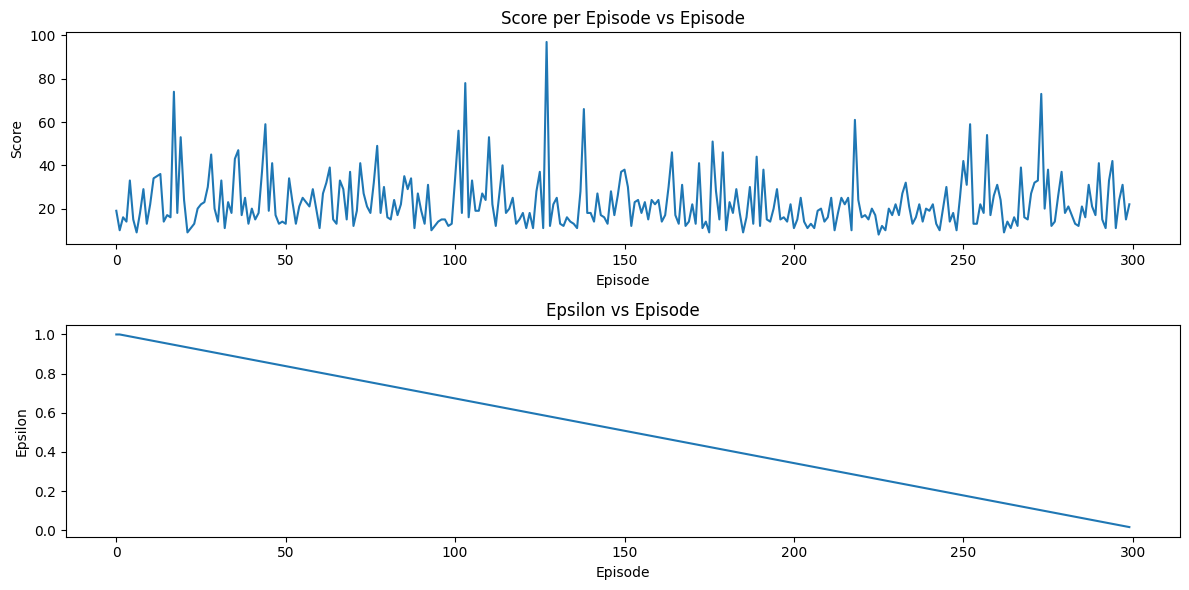

In [84]:
agent = Agent(algorithm='SARSA')
agent.train()